# **Try : 1 Accuracy on Train Data Evaluated DenseNet 1**
**Dataset : CIFAR10**

**Step 1: Importing Libraries**

In [0]:
from tensorflow.keras.layers import BatchNormalization, ReLU,GlobalAveragePooling2D,GlobalAvgPool2D
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import time

**Step2: Loading Data**

In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_labels = train_labels.reshape((-1))

train_data   = tf.data.Dataset.from_tensor_slices((train_images.reshape([-1,32,32,3]).astype(np.float32),train_labels.astype(np.int32)))
train_data= train_data.shuffle(buffer_size=60000).batch(500).repeat()

test_labels = test_labels.reshape((-1))
test_data = tf.data.Dataset.from_tensor_slices((test_images.reshape([-1,32,32,3]).astype(np.float32), test_labels.astype(np.int32))).batch(10000)

170500096/170498071 [==============================] - 14s 0us/step


**Step3: Defining BatchNormalization, ReLU and Convo Layer Function**

The function takes tensor as an argument, number of filters and kernel size(filter size).

In [0]:
def bn_relu_conv(inp,filters,k_size):
  inp_map = BatchNormalization()(inp)
  inp_map = ReLU()(inp_map)
  inp_map = tf.keras.layers.Conv2D(filters,kernel_size=k_size,padding='same')(inp_map)#32x32x32
  return inp_map

**Step4: Defining Dense Block**

takes 'tensor' and reps in repetitions. exampe in first case it will take rep = 6.

conv1 layer is having kernel size = 3 and number of filters is 32
conv2 is identical to conv1
further conv2 and initial input(tensor) gets concatinated

example:                         
input image shape = 32x32x3                                  
tensor shape = 32x32x32(1st convo layer, input to block1)                                       
                                
                                                 
                                                                                    
when rep = 1                                          
conv1 shape = 32x32x32                                  
conv2 shape = 32x32x32                                   
tensor updated shape = 32x32x64
                                  
                                            
                                                                     
when rep = 2                  
conv1 = 32x32x32                              
conv2 = 32x32x32                              
tensor updated shape = 32x32x96

and so on........................                          
By doing this, we are able to make sure that output from previous layers in a block are passed on to every succesive layers.
                                       
                                       



In [0]:
def dense_block(tensor,rep):
  for i in range(rep):
    conv1 = bn_relu_conv(tensor,filters = 32,k_size = 3)#32x32x32
    conv2 = bn_relu_conv(conv1,  filters = 32,k_size = 3)#32x32x32
    tensor = tf.keras.layers.concatenate([tensor, conv2])
    #print(tensor)
  return (tensor)


**Step5: Defining Transition Block**                   
Each dense block produces( N x N x 32 ) filter maps. These maps are convoluted into a single layer and and down sampling is done using average pooling.

This has following benefits:-
* prevent overfitting
* prevent overshooting parameter counts

In [0]:
def transition_layer(concatinated_conv):
  #f = int(tf.keras.backend.int_shape(concatinated_conv)[-1] * theta)
  trans_conv = bn_relu_conv(concatinated_conv, filters=1, k_size=3)
  trans_conv = tf.keras.layers.MaxPooling2D(pool_size=2)(trans_conv)
  #print(trans_conv)
  return trans_conv

**Defining Hyperparameters and other parts of code**
The repetitions suggested here are from the paper'Densely connected convolutional networks' by 'Gao Huang'

In [0]:
repetitions = 3,6,12,8
inp = tf.keras.layers.Input((32,32,3))

The snipet below is the entry point to the main part of the program. This will generate a convolution layer that will be further fed to the 1st dense block.

In [0]:
tensor = bn_relu_conv(inp, filters= 32, k_size=3)

The snipet below uses both dense block and transition block and provides the dense net in the end

In [0]:
for reps in repetitions:
  concatinated_conv = dense_block(tensor,reps)
  tensor         = transition_layer(concatinated_conv)


In [0]:
#final_conv_layer= bn_relu_conv(concatinated_conv, filters=1, k_size=3)
#final_conv_layer = tf.keras.layers.MaxPooling2D(pool_size=2)(final_conv_layer)

This part is the mlp. The output from convo layer is fed to 10 output units with a softmax fucntion. This data from convo layer is 1st flattened and then used in output

In [0]:
flat = tf.keras.layers.Flatten()(tensor)
output1 = tf.keras.layers.Dense(64, activation='relu')(flat)
output  = tf.keras.layers.Dense(10, activation= 'softmax')(output1)

initializing the model

In [0]:
model = tf.keras.Model(inp, output)

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_184 (BatchN (None, 32, 32, 3)    12          input_3[0][0]                    
__________________________________________________________________________________________________
re_lu_184 (ReLU)                (None, 32, 32, 3)    0           batch_normalization_184[0][0]    
__________________________________________________________________________________________________
conv2d_184 (Conv2D)             (None, 32, 32, 32)   896         re_lu_184[0][0]                  
____________________________________________________________________________________________

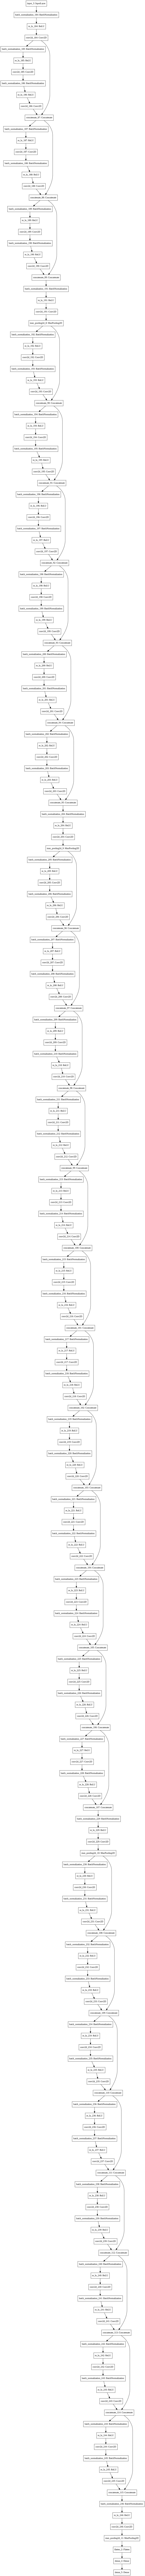

In [0]:
tf.keras.utils.plot_model(model, 'Model.png')

In [0]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.fit(train_data,epochs=100,steps_per_epoch=200)

Epoch 1/100
200/200 [==============================] - 91s 454ms/step - loss: 2.0962 - accuracy: 0.3525
Epoch 2/100
200/200 [==============================] - 91s 455ms/step - loss: 2.0723 - accuracy: 0.3815
Epoch 3/100
200/200 [==============================] - 91s 454ms/step - loss: 2.0568 - accuracy: 0.3982
Epoch 4/100
200/200 [==============================] - 91s 453ms/step - loss: 2.0460 - accuracy: 0.4098
Epoch 5/100
200/200 [==============================] - 91s 454ms/step - loss: 2.0325 - accuracy: 0.4228
Epoch 6/100
200/200 [==============================] - 91s 455ms/step - loss: 2.0194 - accuracy: 0.4368
Epoch 7/100
200/200 [==============================] - 91s 454ms/step - loss: 2.0063 - accuracy: 0.4502
Epoch 8/100
200/200 [==============================] - 91s 454ms/step - loss: 1.9965 - accuracy: 0.4602
Epoch 9/100
200/200 [==============================] - 91s 454ms/step - loss: 1.9802 - accuracy: 0.4762
Epoch 10/100
200/200 [==============================] - 91s 454m

# **Try 2: DenseNet - 121 K=32 8 Mil params verified**

In [2]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_labels = train_labels.reshape((-1))
test_labels = test_labels.reshape((-1))
input_tensor = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

170500096/170498071 [==============================] - 11s 0us/step


In [6]:
#Custom Conolution Layer is required
def customConv(input_tensor , no_filters, filter_size, strides_length=1):
  input_tensor = tf.keras.layers.BatchNormalization()(input_tensor)
  input_tensor = tf.keras.layers.ReLU()(input_tensor)
  input_tensor = tf.keras.layers.Conv2D(filters=no_filters , kernel_size= filter_size, strides = strides_length, padding = 'same')(input_tensor)
  return input_tensor

#Should implement the dense, transition architecture [1,3]
def customBlock(input_tensor, dense_repetitions, padding_input, no_filters):
  for idx in range(0,len(dense_repetitions)):
    temp_idx = 0
    if(idx == len(dense_repetitions) - 1):
      while(temp_idx < dense_repetitions[idx]):
        temp_idx = temp_idx + 1
        temp_tensor = customConv(input_tensor, filter_size = 1, no_filters = 4 * no_filters)
        temp_tensor = customConv(temp_tensor, filter_size = 3, no_filters = no_filters)
        input_tensor = tf.keras.layers.concatenate([input_tensor, temp_tensor])
    else:
      while(temp_idx < dense_repetitions[idx]):
        temp_idx = temp_idx + 1
        temp_tensor = customConv(input_tensor, filter_size = 1, no_filters = 4 * no_filters)
        temp_tensor = customConv(temp_tensor, filter_size = 3, no_filters = no_filters)
        input_tensor = tf.keras.layers.concatenate([input_tensor, temp_tensor])
      no_filters_half = (tf.keras.backend.int_shape(input_tensor)[-1] // 2 )
      print(no_filters_half)
      input_tensor = customConv(input_tensor = input_tensor, filter_size = 1, no_filters = no_filters_half)
      input_tensor = tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=2, padding = padding_input)(input_tensor)
      
  return input_tensor    

#sample shape for test
input = tf.keras.layers.Input((224,224,3))

#Convolution First
input_tensor = tf.keras.layers.Conv2D(32, kernel_size = (7,7), padding='same')(input)
input_tensor = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides = 2, padding = 'same')(input_tensor)

#custom Block
input_tensor = customBlock(input_tensor, dense_repetitions = [6,12,24,16] , padding_input= 'same', no_filters= 32)

#Classification Block 
input_tensor = tf.keras.layers.GlobalAvgPool2D()(input_tensor)
output = tf.keras.layers.Dense(1000, activation='softmax')(input_tensor)
built_model = tf.keras.Model(input, output)
built_model.summary()
tf.keras.utils.plot_model(built_model, 'Model.png')

112
248
508
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 224, 224, 32) 4736        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_122[0][0]                 
__________________________________________________________________________________________________
batch_normalization_119 (BatchN (None, 112, 112, 32) 128         max_pooling2d_1[0][0]            
________________________________________________________________________________